# Gen data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import random
import os
sys.path.append("..")
from global_variables import *
from escape_map import EscapeMap, load_escape_map_from_csv,gen_artif_data, score_seq_batch
from utils import get_Kd

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


In [2]:
#import utils from ../rbm
pgm_dir=('../')
sys.path.append(pgm_dir+'./utilities')

# Now safe to import
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils  # rbm.py must be alongside this file

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Reproducibility (optional) ---
np.random.seed(42)

# --- Load model and set base concentrations ---
model = load_escape_map_from_csv("../fitness/params_sigmoid_diff.csv")
model.raw_concentrations = -12.0 * np.ones(len(KD_VECTORS), dtype=np.float64)


In [4]:
seqbeta=Proteins_utils.load_FASTA('generated_sequences_beta.fasta', drop_duplicates=False)

df_scores = pd.read_csv("generated_sequences_scores_beta.csv")
df_scores_esmif = pd.read_csv("generated_sequences_esmif_beta.csv")
df_scores['log_likelihood']=df_scores_esmif['log_likelihood']
df_scores['score']=-model(seqbeta)
#filter on beta >= 0.5
df_scores = df_scores[df_scores['coeff_beta']>=0.8]
df_scores

,seq_id,score,coeff_beta,log_likelihood
100,seq100,53.257119,0.8,-1.746571
101,seq101,53.238796,0.8,-1.760923
102,seq102,53.415175,0.8,-1.797290
103,seq103,53.439668,0.8,-1.808266
104,seq104,53.352385,0.8,-1.788214
...,...,...,...,...
495,seq495,54.936797,3.0,-1.555762
496,seq496,55.145971,3.0,-1.547031
497,seq497,55.145971,3.0,-1.547031
498,seq498,55.145971,3.0,-1.547032


In [5]:
score_wt = score_seq_batch(model, WT_SEQ) / model.total_beta  # (N,)
print("WT score:", score_wt)


WT score: 53.24577331542969


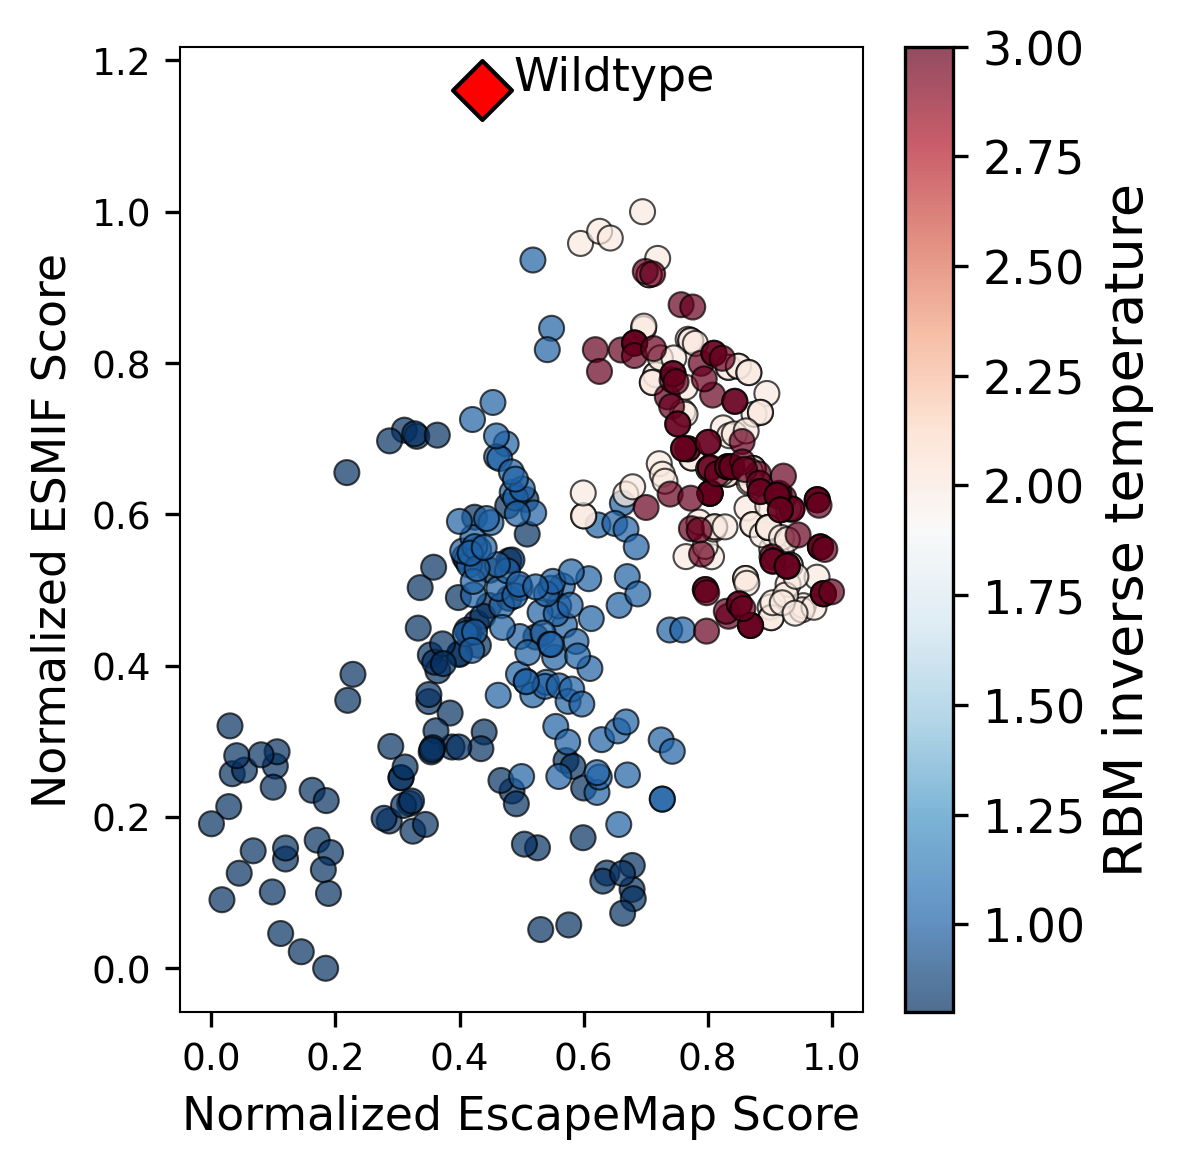

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Normalization helpers ---
def minmax_norm(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize x and y axes
df_scores['score_norm'] = minmax_norm(df_scores['score'])
df_scores['loglike_norm'] = minmax_norm(df_scores['log_likelihood'])

# Normalize WT point using the same scaling
score_wt_norm = (score_wt - df_scores['score'].min()) / (df_scores['score'].max() - df_scores['score'].min())
loglike_wt_norm = (-1.1953541863824904 - df_scores['log_likelihood'].min()) / \
                  (df_scores['log_likelihood'].max() - df_scores['log_likelihood'].min())

# Create figure
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

# Scatter plot
scatter = ax.scatter(
    df_scores['score_norm'], 
    df_scores['loglike_norm'], 
    c=df_scores['coeff_beta'],     # beta stays raw for coloring
    cmap=plt.get_cmap('RdBu_r'), 
    alpha=0.7, 
    edgecolors='k',
    linewidths=0.5
)

# Add WT point
ax.scatter(score_wt_norm, loglike_wt_norm, 
           color='red', marker='D', s=100, label='Wildtype', edgecolor='black')

ax.annotate('Wildtype', xy=(score_wt_norm, loglike_wt_norm), 
            xytext=(score_wt_norm+0.05, loglike_wt_norm),
            fontsize=11, color='black')

# Colorbar for β
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('RBM inverse temperature', fontsize=13)
cbar.ax.tick_params(labelsize=11)

# Axis labels
ax.set_xlabel('Normalized EscapeMap Score', fontsize=11)
ax.set_ylabel('Normalized ESMIF Score', fontsize=11)

# Ticks and style
ax.tick_params(axis='both', labelsize=9)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()


# Escape Score

In [7]:
seqs=Proteins_utils.load_FASTA('generated_sequences_beta3.fasta', drop_duplicates=False)
MERGED_KD_VECTORS=KD_VECTORS | NEW_KD_VECTORS
seqs.shape


(1000, 178)

In [8]:
log_kd_values=np.array([get_Kd(seq,MERGED_KD_VECTORS , log10=True) for seq in seqs])

ace2_rbm_scores=pd.read_csv('generated_sequences_scores_beta3.csv')['score'].values
log_kd_values.shape#nseeq, n_ab

(1000, 31)

In [9]:
ab_class_df_mapping=pd.read_csv('../exp_data/ab_classification.csv')
class_mapping = ab_class_df_mapping.set_index('condition')['condition_subtype'].to_dict()#condition is antibody name, condition_subtype is class
#add VIR-7229: class 1 and SA44: class 4
class_mapping['VIR-7229'] = 'class 1'
class_mapping['SA55'] = 'class 4'
ab_names=list(MERGED_KD_VECTORS.keys())#ab_names#name of antibodies
#create a dataframe conaining name of antibodies and their class obtained from the mapping
ab_class_df=pd.DataFrame({'antibody':ab_names})
ab_class_df['class'] = ab_class_df['antibody'].map(class_mapping)
ab_class_df


,antibody,class
0,COV2-2050,class 2
1,COV2-2082,class 4
2,COV2-2094,class 4
3,COV2-2096,class 2
4,COV2-2130,class 3
5,COV2-2165,class 1
6,COV2-2196,class 1
7,COV2-2479,class 2
8,COV2-2499,class 3
9,COV2-2677,class 4


(1000, 31)


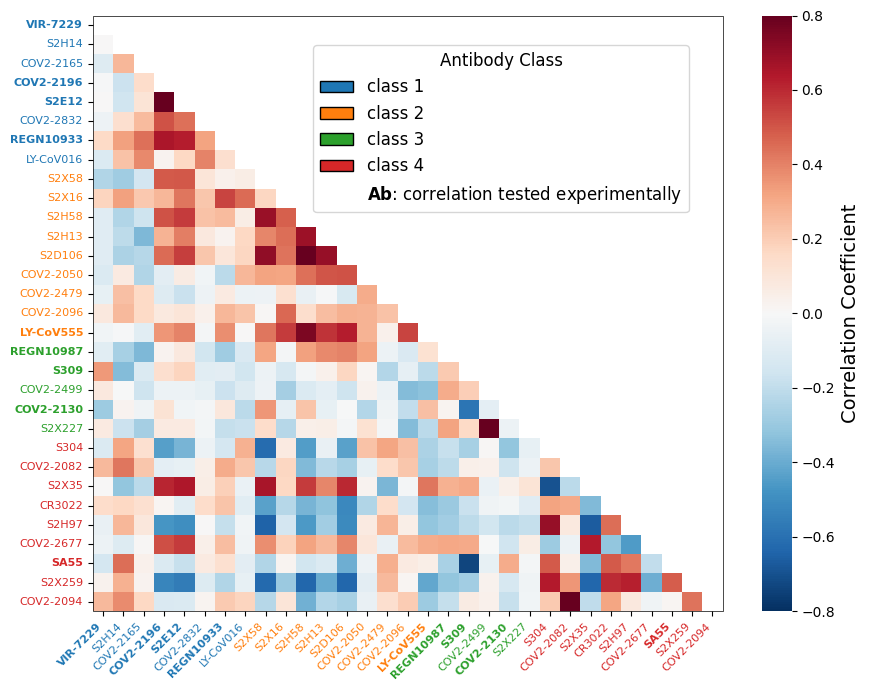

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.patches as patches

# Example data (commented; replace with real data)
# log_kd_values = np.random.rand(5000, 29)
# ab_names = [f'Ab{i+1}' for i in range(29)]
# class_mapping = {f'Ab{i+1}': f'Class{i%3+1}' for i in range(29)}

# Step 1: Create DataFrame for antibodies and their classes
ab_class_df = pd.DataFrame({'antibody': ab_names})
ab_class_df['class'] = ab_class_df['antibody'].map(class_mapping)

# Step 2: Calculate the correlation matrix
if isinstance(log_kd_values, np.ndarray):
    df_log_kd = pd.DataFrame(log_kd_values, columns=ab_names)
else:
    df_log_kd = log_kd_values

k_wt = df_log_kd.mean()
print(df_log_kd.shape)

correlation_matrix = pd.DataFrame(index=ab_names, columns=ab_names)

for i, ab1 in enumerate(ab_names):
    for j, ab2 in enumerate(ab_names):
        if i >= j:  # compute only lower triangle + diagonal
            df_log_kd_trimmed = df_log_kd  # or apply filtering
            if not df_log_kd_trimmed.empty:
                corr_value = df_log_kd_trimmed[[ab1, ab2]].corr().iloc[0, 1]
                correlation_matrix.at[ab1, ab2] = corr_value
                correlation_matrix.at[ab2, ab1] = corr_value

# Step 3: Sort by class
ab_class_df_sorted = ab_class_df.sort_values(by='class')
sorted_ab_names = ab_class_df_sorted['antibody'].tolist()
sorted_corr_matrix = correlation_matrix.loc[sorted_ab_names, sorted_ab_names]
sorted_corr_matrix = sorted_corr_matrix.astype(float)
sorted_corr_matrix.fillna(0, inplace=True)

# Step 4: Create mask and grey out diagonal
mask = np.triu(np.ones_like(sorted_corr_matrix, dtype=bool), k=1)  # upper triangle mask
np.fill_diagonal(sorted_corr_matrix.values, np.nan)  # diagonal to NaN

# Create custom colormap with grey for NaNs
cmap = plt.get_cmap('RdBu_r')

cmap.set_bad(color='white')

# Define class colors
class_colors = ab_class_df_sorted['class'].drop_duplicates().reset_index(drop=True)
color_map = {k: f"C{i}" for i, k in enumerate(class_colors)}

# Step 5: Plot
plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    sorted_corr_matrix,
    annot=False,
    cmap=cmap,
    xticklabels=sorted_ab_names,
    yticklabels=sorted_ab_names,
    vmin=-0.8,
    vmax=0.8,
    mask=mask,
    cbar_kws={'label': 'Correlation Coefficient'}
)

# Set the font size of the colorbar label
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Correlation Coefficient', fontsize=14)

# Define class legend elements
legend_elements = [
    Patch(facecolor=color_map[class_name], edgecolor='black', label=class_name)
    for class_name in color_map
]
legend_elements.append(
    Patch(facecolor='none', edgecolor='none', label=r"$\bf{Ab}$: correlation tested experimentally")
)

# Add legend outside the heatmap
ax.legend(
    handles=legend_elements,
    title="Antibody Class",
    bbox_to_anchor=(0.35, 0.95),
    loc='upper left',
    borderaxespad=0.,
    fontsize=12,
    title_fontsize=12
)

# Color axis labels by class, and bold specific antibody names
highlight_abs = {"S2E12", "REGN10933", "COV2-2196", "VIR-7229", "LY-CoV555", "S309", "COV2-2130", "REGN10987", "SA55"}

xticks = ax.get_xticklabels()
yticks = ax.get_yticklabels()

for i, tick in enumerate(xticks):
    ab = ab_class_df_sorted.iloc[i]['antibody']
    tick.set_color(color_map[ab_class_df_sorted.iloc[i]['class']])
    if ab in highlight_abs:
        tick.set_fontweight('bold')

for i, tick in enumerate(yticks):
    ab = ab_class_df_sorted.iloc[i]['antibody']
    tick.set_color(color_map[ab_class_df_sorted.iloc[i]['class']])
    if ab in highlight_abs:
        tick.set_fontweight('bold')

ax.set_xticklabels(xticks, rotation=45, horizontalalignment='right')
ax.set_yticklabels(yticks, rotation=0, horizontalalignment='right')
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# Add black frame around the heatmap matrix
num_labels = len(sorted_ab_names)
rect = patches.Rectangle(
    (0, 0),                         # bottom-left corner in data coords
    width=num_labels,              # width of the matrix
    height=num_labels,             # height of the matrix
    linewidth=0.5,
    edgecolor='black',
    facecolor='none',
    clip_on=False                  # ensures full visibility of the frame
)
ax.add_patch(rect)

plt.tight_layout()
plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_13064\3037489095.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


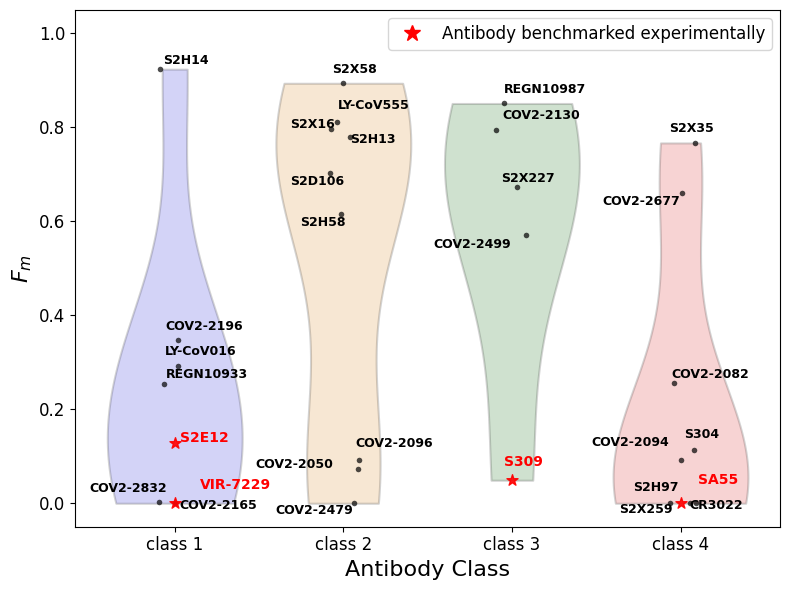

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.text import Annotation

# --- 1) Per-antibody fraction with log10(Kd) > 5 ---
# log_kd_values: shape (n_seq, n_ab), values are log10(Kd) because log10=True above
# ab_names: list of antibodies in the same order as columns of log_kd_values

# (Optional) cover both spellings just in case

# Fix names in our working list for nicer labels
ab_names_fixed = ab_names  # no changes needed here

arr = np.asarray(log_kd_values, dtype=float)          # (n_seq, n_ab)
is_valid = ~np.isnan(arr)
is_above = (arr > -6) & is_valid                       # threshold in log10 space

# Avoid divide-by-zero for columns with no valid data
denom = is_valid.sum(axis=0)                          # per-antibody valid counts
num = is_above.sum(axis=0)
with np.errstate(invalid='ignore', divide='ignore'):
    frac = np.where(denom > 0, num / denom, np.nan)   # fraction in [0,1]

kd_df = pd.DataFrame({
    'antibody': ab_names_fixed,
    'percentage': frac  # fraction, not 0–100
})

# --- 2) Attach class labels and keep only antibodies with a known class ---
ab_class_df = pd.DataFrame({'antibody': ab_names_fixed})
ab_class_df['class'] = ab_class_df['antibody'].map(class_mapping)

merged_df = kd_df.merge(ab_class_df, on='antibody', how='left')
merged_df = merged_df.dropna(subset=['class']).reset_index(drop=True)

# --- 3) Plot: one violin per class ---
class_colors = {
    "class 1": "blue",
    "class 2": "darkorange",
    "class 3": "green",
    "class 4": "red"
}

# Consistent class order on x-axis
wanted_order = ['class 1', 'class 2', 'class 3', 'class 4']
class_order = [c for c in wanted_order if c in merged_df['class'].unique()]

plt.figure(figsize=(8, 6))

# Violin plot (no alpha arg in seaborn.violinplot)
sns.violinplot(
    x='class', y='percentage', data=merged_df, inner=None,
    palette=class_colors, linewidth=1.5, saturation=0.7, order=class_order, cut=0, alpha=0.2
)

# Scatter all antibodies except the highlighted ones
exclude_abs = ['S309', 'S2E12', 'VIR-7229', 'SA55']
filtered_df = merged_df[~merged_df['antibody'].isin(exclude_abs)]
sns.stripplot(
    x='class', y='percentage', data=filtered_df, jitter=True,
    alpha=0.7, color='black', size=4, zorder=3, order=class_order
)

# Highlighted antibodies as red stars + labels
highlight_df = merged_df[merged_df['antibody'].isin(exclude_abs)]
texts = []
for _, row in highlight_df.iterrows():
    x_pos = class_order.index(row['class'])
    plt.scatter(x_pos, row['percentage'], color='red', marker='*', s=70, zorder=4, alpha=0.9)
    texts.append(plt.text(x=x_pos, y=row['percentage'] + 0.015, s=row['antibody'],
                          fontsize=10, color='red', weight='bold', ha='center', va='bottom'))

# Optional: label the rest (can be busy—comment out if cluttered)
label_df = merged_df[~merged_df['antibody'].isin(exclude_abs)]
for _, row in label_df.iterrows():
    x_pos = class_order.index(row['class'])
    text = Annotation(
        text=row['antibody'],
        xy=(x_pos, row['percentage']),
        xytext=(x_pos - 0.02, row['percentage']),
        textcoords='data',
        ha='center', fontsize=9, color='black', weight='bold'
    )
    plt.gca().add_artist(text)
    texts.append(text)

# Tidy label overlaps
adjust_text(
    texts,
    only_move={'points': 'xy'},
    force_points=6.0,
)

# Axes and labels
plt.xlabel('Antibody Class', fontsize=16)
plt.ylabel(r'$F_m$', fontsize=16)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-0.05, 1.05)

# Custom legend for highlighted set
star_marker = plt.Line2D([0], [0], marker='*', color='red', linestyle='',
                         markersize=12, label='Antibody benchmarked experimentally')
plt.legend(handles=[star_marker], fontsize=12, loc='upper right')
#log scale on y axis
plt.tight_layout()
plt.show()


# 2D projection

In [ ]:
model_no_ab = load_escape_map_from_csv("../fitness/params_sigmoid_diff.csv")
model_no_ab.raw_concentrations = -12.0 * np.ones(len(KD_VECTORS), dtype=np.float64)

model = load_escape_map_from_csv("../fitness/params_sigmoid_diff.csv")
VOCS=Proteins_utils.load_FASTA('../seq_data/sequences_vocs.fasta', drop_duplicates=False)[:,BEGIN:-END]
VOCS.shape
model(seqs)
model(VOCS)
#
log_kd_vocs=np.array([get_Kd(seq, KD_VECTORS, log10=True) for seq in VOCS])
viability_voc=-model_no_ab(VOCS)
viability_seqs=-model_no_ab(seqs)



In [ ]:
# log_kd_values: (n_seq, n_ab)
# ab_names_fixed: list of length n_ab
# class_mapping: dict {antibody -> class label}

import numpy as np
import pandas as pd
from typing import Mapping, Sequence, Optional

def mean_log_kd_per_class(
    log_kd_values: np.ndarray,
    ab_names_fixed: Sequence[str],
    class_mapping: Mapping[str, str],
    wanted_order: Optional[Sequence[str]] = ("class 1", "class 2", "class 3", "class 4"),
) -> pd.DataFrame:
    """
    Compute per-sequence mean log10(Kd) by antibody class.

    Returns a DataFrame of shape (n_seq, n_classes).
    """
    arr = np.asarray(log_kd_values, dtype=float)
    if arr.ndim != 2:
        raise ValueError("log_kd_values must be 2D: (n_seq, n_ab).")
    if arr.shape[1] != len(ab_names_fixed):
        raise ValueError("Length of ab_names_fixed must match number of antibody columns.")

    classes = pd.Series(ab_names_fixed, dtype="object").map(class_mapping)

    # keep only antibodies with a class
    keep = classes.notna().to_numpy()
    if not np.any(keep):
        return pd.DataFrame(index=np.arange(arr.shape[0]))

    arr_kept = arr[:, keep]
    class_labels = classes[keep].to_numpy()

    # build per-sequence mean log10(Kd) per class (NaN-safe)
    per_seq_class_mean = {}
    for c in np.unique(class_labels):
        cols = class_labels == c
        per_seq_class_mean[c] = np.nanmean(arr_kept[:, cols], axis=1)

    df = pd.DataFrame(per_seq_class_mean)  # shape: (n_seq, n_classes)

    # optional: enforce a specific column order
    if wanted_order is not None:
        df = df[
            [c for c in wanted_order if c in df.columns]
            + [c for c in df.columns if c not in wanted_order]
        ]

    return df
df_seqs = mean_log_kd_per_class(log_kd_values, ab_names_fixed, class_mapping)
df_vocs = mean_log_kd_per_class(log_kd_vocs, ab_names_fixed, class_mapping)

print(df_vocs)
# viability_voc=-model_no_ab(VOCS)
# viability_voc=-model_no_ab(seqs)

viability_vocs=np.array([get_Kd(seq, ACE2_KD_VECTOR, log10=True)[0,0] for seq in VOCS])

viability_seqs=np.array([get_Kd(seq, ACE2_KD_VECTOR, log10=True)[0,0] for seq in seqs])
print(viability_vocs)


ValueError: Length of ab_names_fixed must match number of antibody columns.

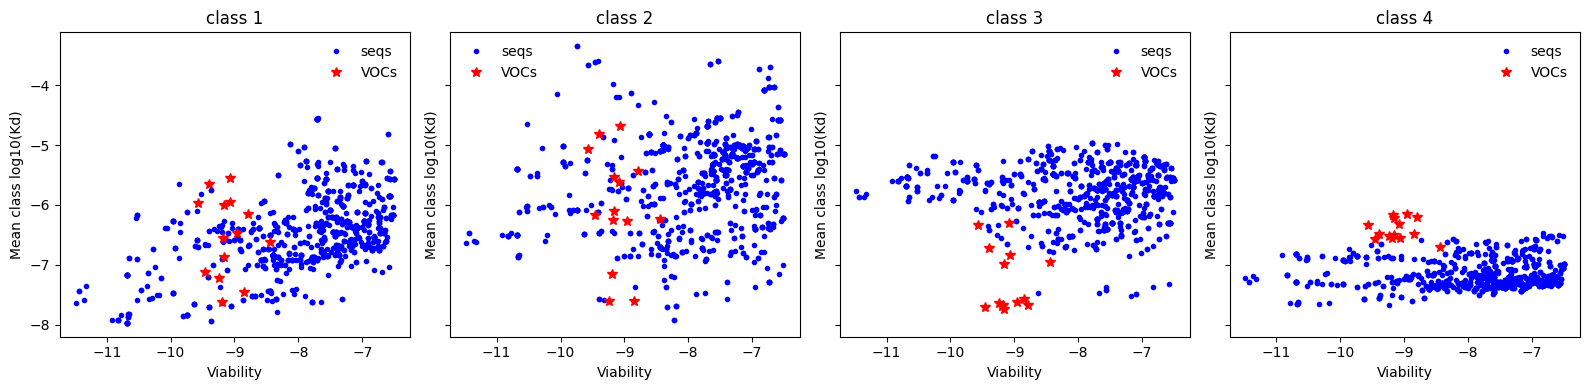

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_viability_vs_class_kd(
    df_seqs, df_vocs, viability_seqs, viability_vocs, classes_order=None
):
    # inputs: df_* from mean_log_kd_per_class; viability_* shape (n_seq,) and (n_voc,)

    v_seqs = np.asarray(viability_seqs, dtype=float)
    v_vocs = np.asarray(viability_vocs, dtype=float)

    if v_seqs.shape[0] != df_seqs.shape[0]:
        raise ValueError("viability_seqs length must match df_seqs rows.")
    if v_vocs.shape[0] != df_vocs.shape[0]:
        raise ValueError("viability_vocs length must match df_vocs rows.")

    classes = list(sorted(set(df_seqs.columns).union(set(df_vocs.columns))))
    if classes_order:
        classes = [c for c in classes_order if c in classes] + [c for c in classes if c not in classes_order]

    n = len(classes)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharex=True, sharey=True)

    if n == 1:
        axes = [axes]

    for ax, c in zip(axes, classes):
        # SEQS
        if c in df_seqs.columns:
            y = df_seqs[c].to_numpy()
            m = ~np.isnan(y)
            ax.plot(v_seqs[m], y[m], "o", markersize=3, label="seqs", color="blue")
        # VOCs
        if c in df_vocs.columns:
            yv = df_vocs[c].to_numpy()
            mv = ~np.isnan(yv)
            ax.plot(v_vocs[mv], yv[mv], "*", markersize=7, label="VOCs", color="red")

        ax.set_title(c)
        ax.set_xlabel("Viability")
        ax.set_ylabel("Mean class log10(Kd)")
        ax.legend(loc="best", frameon=False)

    plt.tight_layout()
    plt.show()

# # --- your variables ---
# df_seqs = mean_log_kd_per_class(log_kd_values, ab_names_fixed, class_mapping)
# df_vocs = mean_log_kd_per_class(log_kd_vocs, ab_names_fixed, class_mapping)

# # fix your naming:
# viability_vocs = -model_no_ab(VOCS)
# viability_seqs = -model_no_ab(seqs)

plot_viability_vs_class_kd(
    df_seqs, df_vocs, viability_seqs, viability_vocs,
    classes_order=["class 1", "class 2", "class 3", "class 4"]  # optional
)


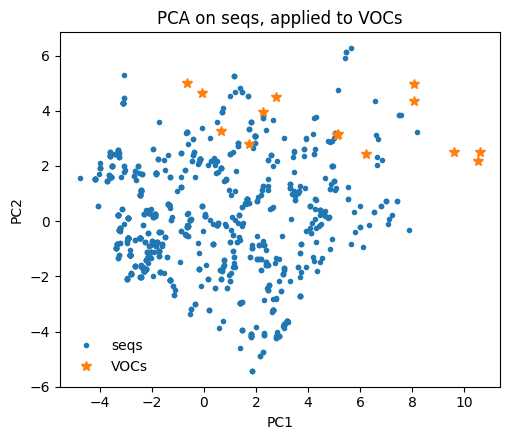

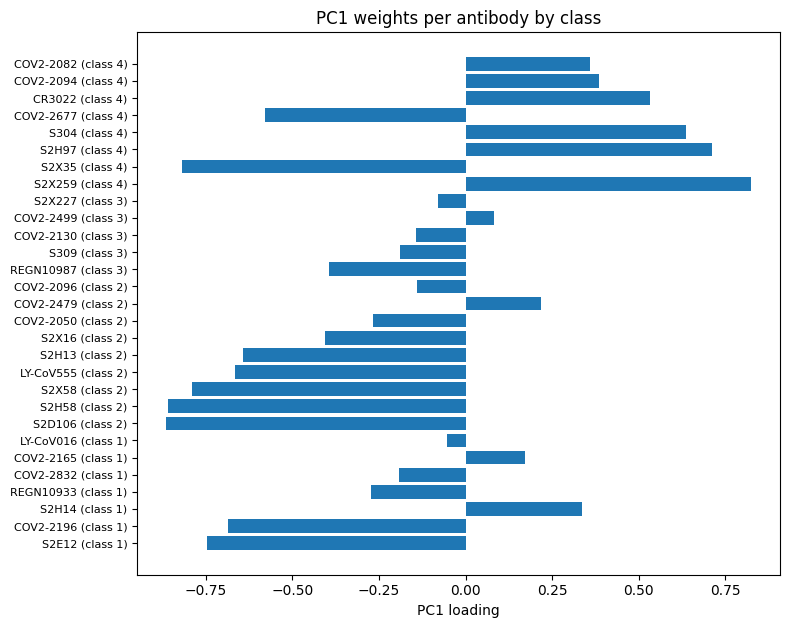

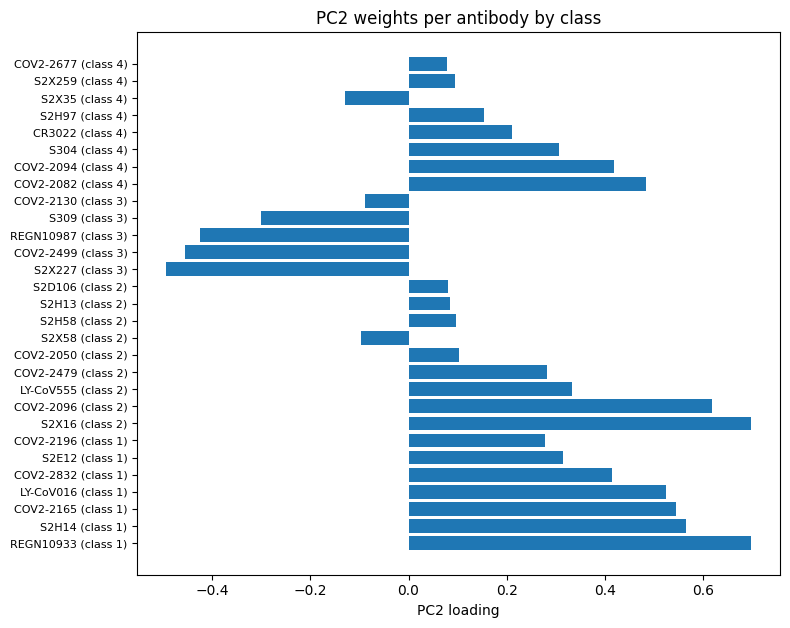

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def _norm(s):
    return str(s).strip()

def _map_classes(ab_names_fixed, class_mapping):
    # normalize keys and names to avoid NaNs from whitespace/mismatch
    cmap = { _norm(k): v for k, v in class_mapping.items() }
    classes = [cmap.get(_norm(a), np.nan) for a in ab_names_fixed]
    return pd.Series(classes, index=ab_names_fixed, dtype="object")

def pca_fit_on_seqs_apply_to_vocs(
    log_kd_values, log_kd_vocs, ab_names_fixed, class_mapping, n_components=2
):
    imp = SimpleImputer(strategy="mean").fit(log_kd_values)
    Xs = imp.transform(log_kd_values)
    Xv = imp.transform(log_kd_vocs)

    sc = StandardScaler(with_mean=True, with_std=True).fit(Xs)
    Xs_std = sc.transform(Xs)
    Xv_std = sc.transform(Xv)

    pca = PCA(n_components=n_components, svd_solver="full", random_state=0).fit(Xs_std)
    Z_seqs = pca.transform(Xs_std)[:, :2]
    Z_vocs = pca.transform(Xv_std)[:, :2]

    # loadings per antibody
    loadings = pca.components_.T[:, :2] * np.sqrt(pca.explained_variance_[:2])
    load_df = pd.DataFrame(loadings, index=ab_names_fixed, columns=["PC1", "PC2"])
    load_df["class"] = _map_classes(ab_names_fixed, class_mapping).fillna("unlabeled")
    return pca, Z_seqs, Z_vocs, load_df

def plot_pca_2d(Z_seqs, Z_vocs):
    plt.figure(figsize=(5.2, 4.5))
    plt.plot(Z_seqs[:, 0], Z_seqs[:, 1], "o", markersize=3, label="seqs")
    plt.plot(Z_vocs[:, 0], Z_vocs[:, 1], "*", markersize=7, label="VOCs")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(frameon=False)
    plt.title("PCA on seqs, applied to VOCs")
    plt.tight_layout(); plt.show()

def plot_component_weights_by_class(load_df: pd.DataFrame, class_order=None):
    # optional explicit class order
    if class_order is not None:
        load_df = load_df.copy()
        load_df["class"] = pd.Categorical(load_df["class"], class_order, ordered=True)

    for comp in ["PC1", "PC2"]:
        df = load_df.copy()
        df["_abs"] = df[comp].abs()
        df.sort_values(by=["class", "_abs"], ascending=[True, False], inplace=True)

        plt.figure(figsize=(8, max(3, 0.22 * len(df))))
        y = np.arange(len(df))
        plt.barh(y, df[comp].values)
        plt.yticks(y, [f"{ab} ({cl})" for ab, cl in zip(df.index, df["class"])], fontsize=8)
        plt.xlabel(f"{comp} loading"); plt.title(f"{comp} weights per antibody by class")
        plt.tight_layout(); plt.show()

# ---- usage ----
pca, Z_seqs, Z_vocs, load_df = pca_fit_on_seqs_apply_to_vocs(
    log_kd_values, log_kd_vocs, ab_names_fixed, class_mapping
)
plot_pca_2d(Z_seqs, Z_vocs)
plot_component_weights_by_class(load_df, class_order=["class 1","class 2","class 3","class 4"])
